# DATA EXPLORATION

## Import modules

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sn  #Per heatmap
import time
import scipy as sp
import os

Audio-specific modules

In [2]:
import librosa as lb
import librosa.display

Sklearn modules

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.ensemble import RandomForestRegressor

## Load data

Load data from CSV _development_ file.

In [4]:
data = pd.read_csv('./data/development.csv', index_col=0)

In [5]:
display(data)

,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
Id,,,,,,,,,,,,,,,,,,,
0,22050,24.0,female,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,22050,22.5,female,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,22050,22.0,female,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,22050,22.0,female,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,22050,22.0,male,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,22050,24.0,male,english,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.001879,0.111799,2188.853478,[184.5703125],-100.921055,69,281,11,17.461406,audios_development/2929.wav
2929,22050,15.0,female,igbo,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.000339,0.070508,2712.362323,[83.35433468],6.757283,0,0,1,1.509206,audios_development/2930.wav
2930,22050,17.0,female,igbo,994.46484,3989.1785,148.97475,0.009677,0.103535,0.001464,0.058442,2248.698477,[89.10290948],-53.913449,1,9,1,1.645034,audios_development/2931.wav


## Data Extraction

In [6]:
audio_files = os.listdir('./data/audios_development')  #List of audio files names
len(audio_files)  #Number of audio files

2933

In [7]:
#First 10 audio files names
audio_files[:10]

['1.wav',
 '10.wav',
 '100.wav',
 '1000.wav',
 '1001.wav',
 '1002.wav',
 '1003.wav',
 '1004.wav',
 '1005.wav',
 '1006.wav']

### Spectrogram extraction - Single example

Feature extraction from one example audio file

In [8]:
y, sr = lb.load('./data/audios_development/' + audio_files[0])
y, len(y), sr   #Audio array, its length, sampling rate

(array([-0.00048187, -0.00066003, -0.00036648, ...,  0.00093829,
         0.00074567,  0.0010901 ], dtype=float32),
 773850,
 22050)

In [9]:
spectrogram = lb.feature.melspectrogram(y=y, sr=sr, n_mels=40)  #Mel spectrogram of the audio array
log_spectrogram = lb.power_to_db(spectrogram, ref=np.max)  #Conversion to db scale

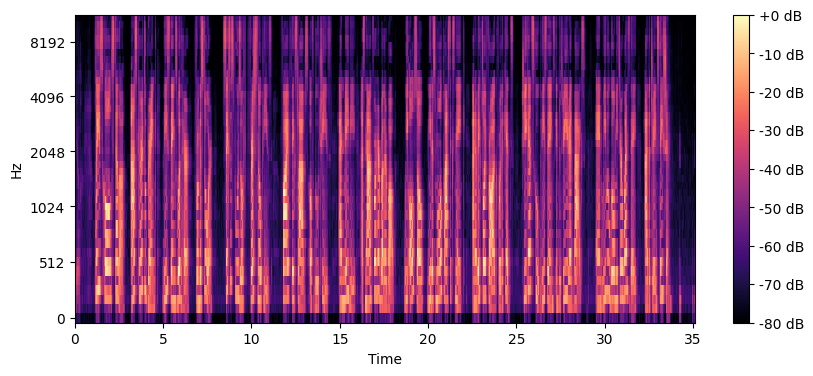

In [10]:
#Graphical visualization of spectrogram
plt.figure(figsize=(10, 4))
lb.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [11]:
#Trim of silence at the biginning and end of the audio
y_trimmed= lb.effects.trim(y,top_db=40)
len(y_trimmed[0])  #Length (in samples) of the trimmed audio

756224

### Data extraction from audio files

In [12]:
def load_data(audio_files, folder_path):
    """
    Load audio files, trim leading and trailing silence, and return audio arrays and lengths in samples.
    Parameters:
    audio_files (list): List of audio file names.
    folder_path (str): Path to the folder containing the audio files.
    Returns:
    audio_arrays (list): List of audio arrays.
    time_stamps (list): List of lengths in samples of the audio files.
    """
    time_stamps = {}
    audio_arrays = []
    for file_name in audio_files:
        if file_name.endswith(".wav"):
            audio_array = librosa.load(folder_path + file_name)
            trimmed_audio_array= lb.effects.trim(audio_array[0])
            time_stamps[file_name] = len(trimmed_audio_array[0])
            audio_arrays.append(trimmed_audio_array[0])
    return (audio_arrays, pd.Series(time_stamps, name='length'))

In [13]:
#Load development recordings
audio_arrays,time_stamps = load_data(audio_files, './data/audios_development/')

## Feature exploration

#### Audio lengths (in samples)

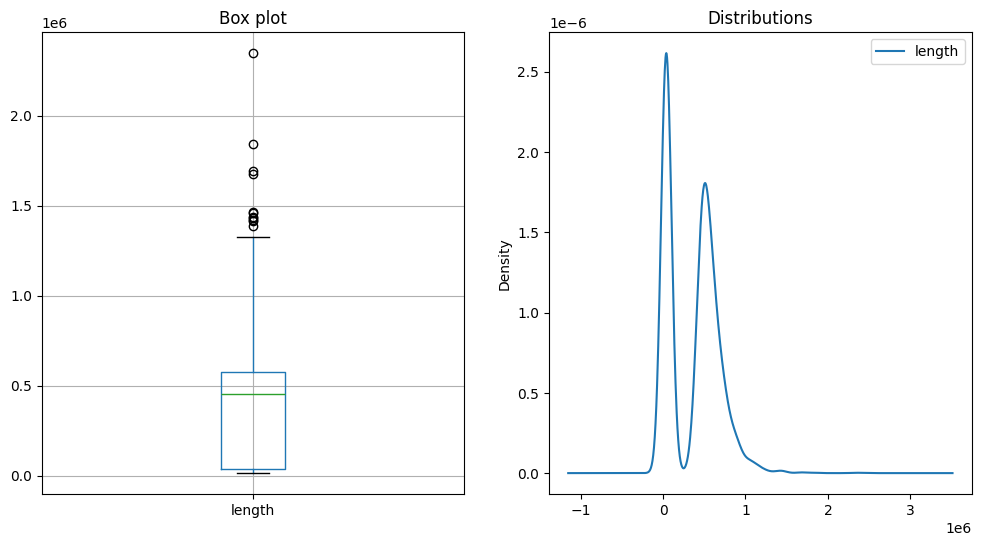

In [14]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
pd.DataFrame(time_stamps).boxplot(ax=axs[0])
axs[0].set_title('Box plot')
pd.DataFrame(time_stamps).plot.density(ax=axs[1],legend=True)
axs[1].set_title('Distributions')
plt.show()

In [15]:
print('Minimum number of samplings:',min(time_stamps))
print('Maximum number of samplings:',max(time_stamps))
print('Mean number of samplings:',np.mean(time_stamps))
print('Ratio between maximum and minimum number of samplings:',max(time_stamps)/min(time_stamps))
print('Ratio between mean and minimum number of samplings:',np.mean(time_stamps)/min(time_stamps))

Minimum number of samplings: 14737
Maximum number of samplings: 2346559
Mean number of samplings: 364163.85714285716
Ratio between maximum and minimum number of samplings: 159.2290832598222
Ratio between mean and minimum number of samplings: 24.71085411839975


In [16]:
#Longest audio file
np.argmax(time_stamps)

np.int64(21)

### Features from csv file

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sampling_rate           2933 non-null   int64  
 1   age                     2933 non-null   float64
 2   gender                  2933 non-null   object 
 3   ethnicity               2933 non-null   object 
 4   mean_pitch              2933 non-null   float64
 5   max_pitch               2933 non-null   float64
 6   min_pitch               2933 non-null   float64
 7   jitter                  2933 non-null   float64
 8   shimmer                 2933 non-null   float64
 9   energy                  2933 non-null   float64
 10  zcr_mean                2933 non-null   float64
 11  spectral_centroid_mean  2933 non-null   float64
 12  tempo                   2933 non-null   object 
 13  hnr                     2933 non-null   float64
 14  num_words               2933 non-null   int64

No null values are present

#### Age

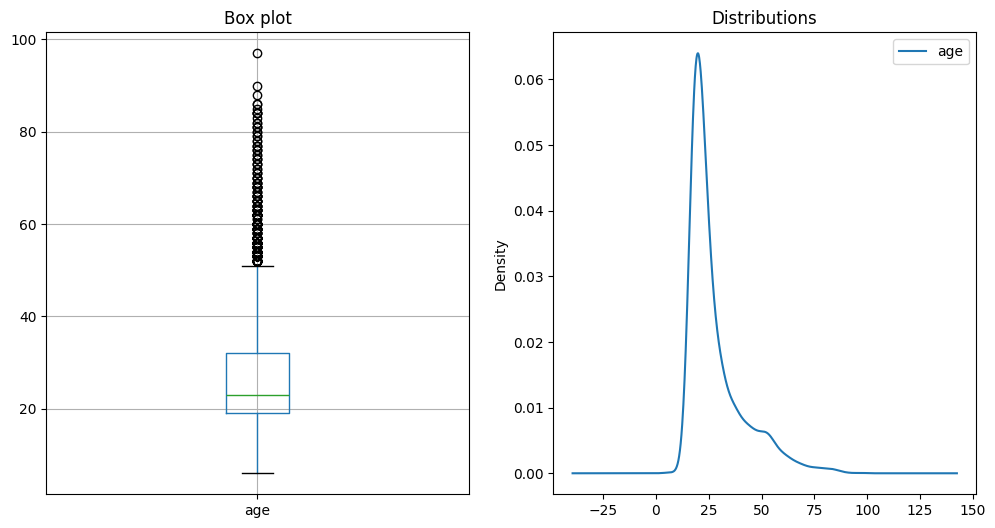

In [18]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
data[['age']].boxplot(ax=axs[0])
axs[0].set_title('Box plot')
data[['age']].plot.density(ax=axs[1],legend=True)
axs[1].set_title('Distributions')
plt.show()

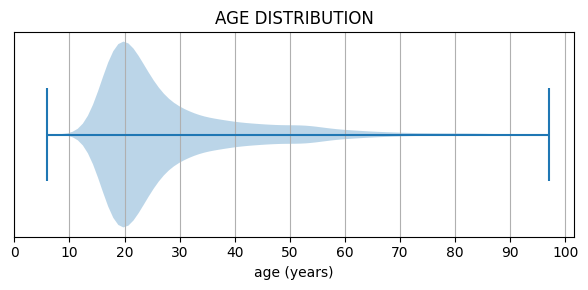

In [19]:
plt.figure(figsize=(6,3))
plt.title('AGE DISTRIBUTION')
plt.violinplot(data['age'].values, orientation='horizontal')
plt.xticks(np.linspace(0,100,11))
plt.yticks([])
plt.xlabel('age (years)')
plt.grid()
plt.tight_layout()
#plt.savefig('age_distribution_violin',dpi=300)
plt.show()

In [20]:
print('Age values:', '\t', np.unique(data['age']))

Age values: 	 [ 6.   7.  15.  15.5 16.  17.  18.  19.  20.  21.  22.  22.5 23.  24.
 25.  26.  27.  27.5 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.
 52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.
 66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
 80.  81.  82.  83.  84.  85.  86.  88.  90.  97. ]


We can also notice that ages are integer numbers or half-integer numbers

#### Sampling rate

In [21]:
sampling_rate=data['sampling_rate'].unique()[0]
print(sampling_rate)

22050


All the recordings have the same sampling rate, equal to 22050

#### Gender

In [22]:
display(data['gender'][data['gender']=='female'].shape)
display(data['gender'][data['gender']=='male'].shape)

(1468,)

(1465,)

The samples distribution across the genders is balanced.

#### Ethnicity

In [23]:
#Number of different ethnicity in the dataset
data['ethnicity'].unique().shape

(165,)

,value,count
78,igbo,1081
42,english,579
7,arabic,102
119,mandarin,65
53,french,63
...,...,...
89,kabyle,1
127,mizo,1
128,moba,1
40,ebira,1


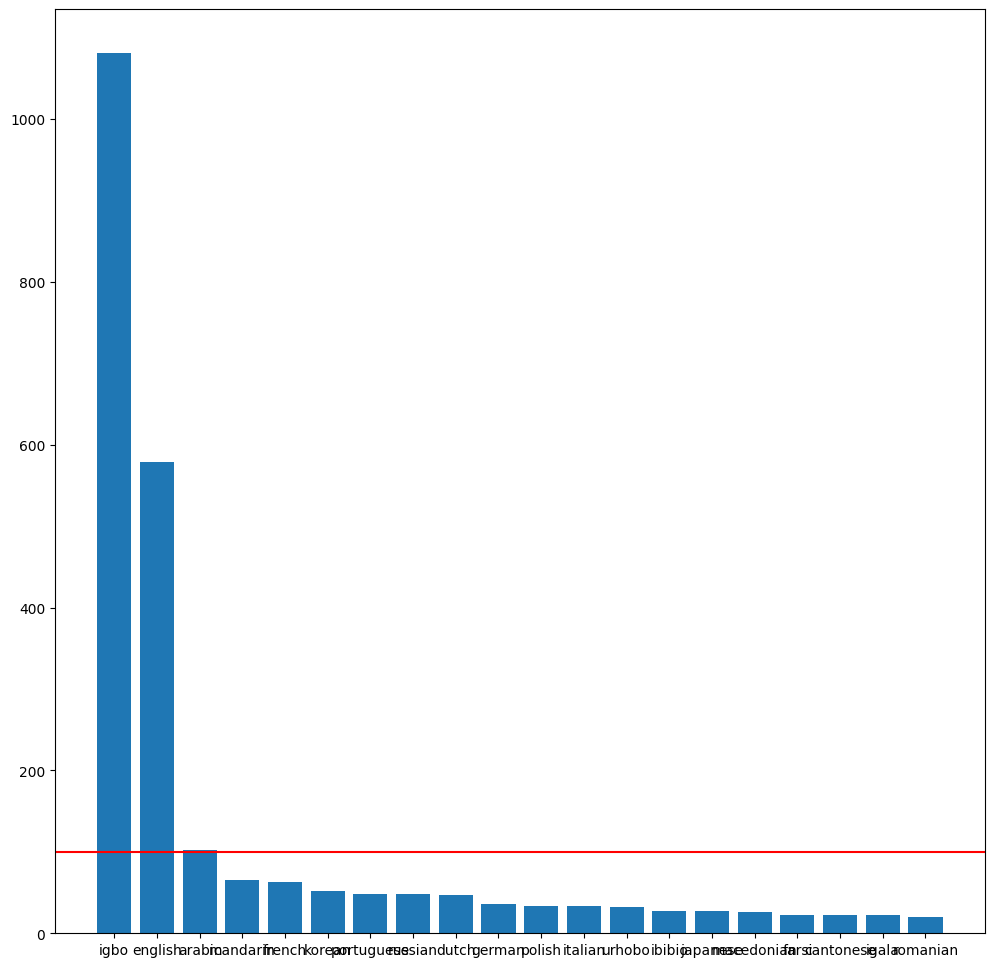

In [24]:
#Ethnicities sorted by number of samples
ethnicity_values, ethnicity_counts = np.unique(data['ethnicity'], return_counts=True)
ethnicity_data = pd.DataFrame(np.vstack((ethnicity_values,ethnicity_counts)).transpose(), columns=['value','count'])
ethnicity_data_ordered = ethnicity_data.sort_values(by=['count'], ascending=False)
display(ethnicity_data_ordered.iloc[:,:])

fig = plt.figure(figsize=(12,12))
plt.bar(ethnicity_data_ordered['value'].iloc[:20], ethnicity_data_ordered['count'].iloc[:20])
plt.axhline(100, c='red')
plt.show()

Horizontal line represents value 100. Only 3 ethnicities have more than 100 samples.

#### Pitch

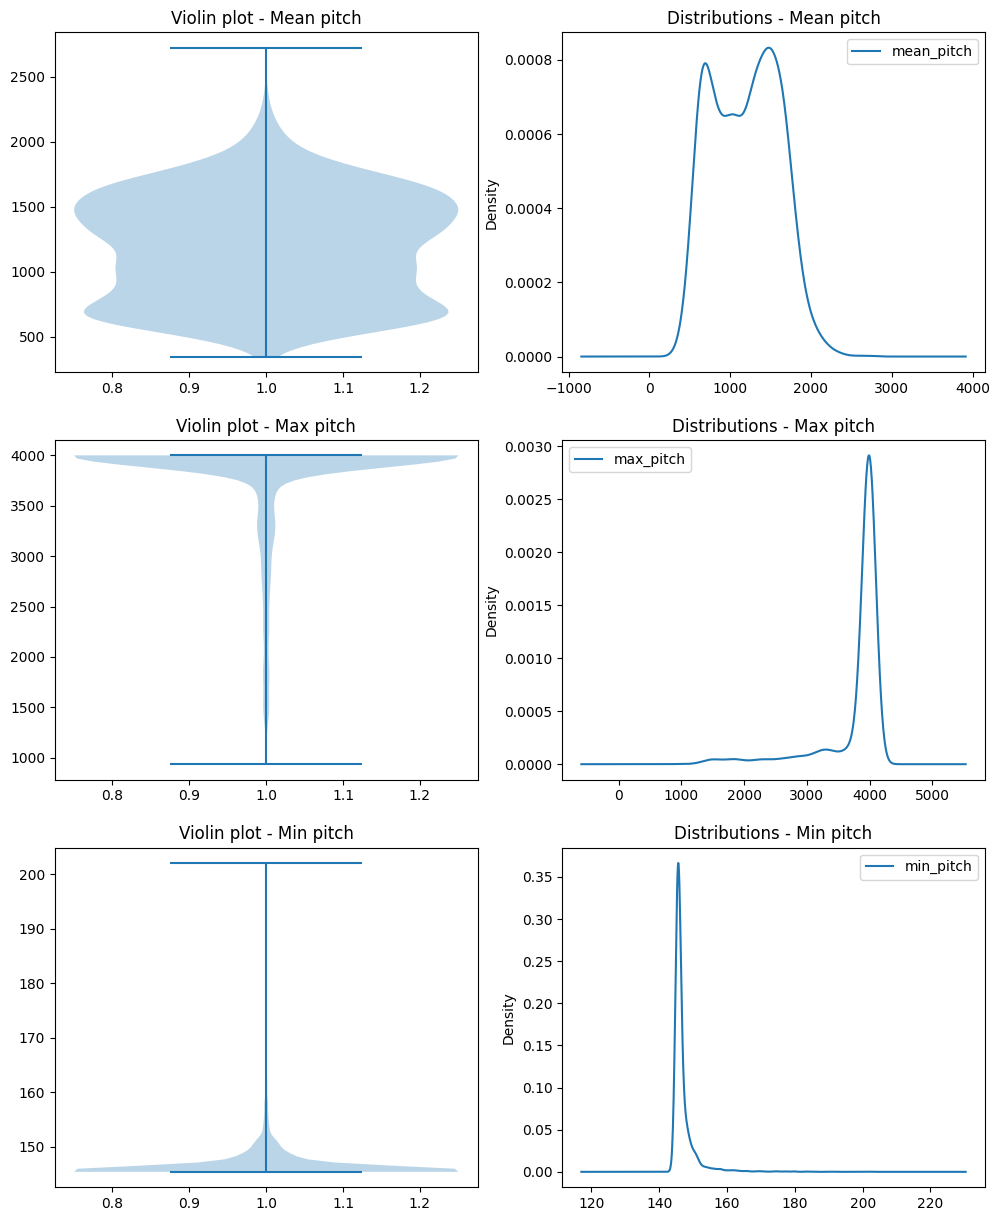

In [25]:
fig, axs = plt.subplots(3,2, figsize=(12,15))
axs[0,0].violinplot(data[['mean_pitch']])
axs[0,0].set_title('Violin plot - Mean pitch')
data[['mean_pitch']].plot.density(ax=axs[0,1],legend=True)
axs[0,1].set_title('Distributions - Mean pitch')
axs[1,0].violinplot(data[['max_pitch']])
axs[1,0].set_title('Violin plot - Max pitch')
data[['max_pitch']].plot.density(ax=axs[1,1],legend=True)
axs[1,1].set_title('Distributions - Max pitch')
axs[2,0].violinplot(data[['min_pitch']])
axs[2,0].set_title('Violin plot - Min pitch')
data[['min_pitch']].plot.density(ax=axs[2,1],legend=True)
axs[2,1].set_title('Distributions - Min pitch')
plt.show()

Max and min pitch are both accumulated against a single value.

In [26]:
#For each integer value in the range, count of samples whose max_pitch is floored to that integer value
max_pitch_values, max_pitch_counts = np.unique(np.floor(data['max_pitch']), return_counts=True)

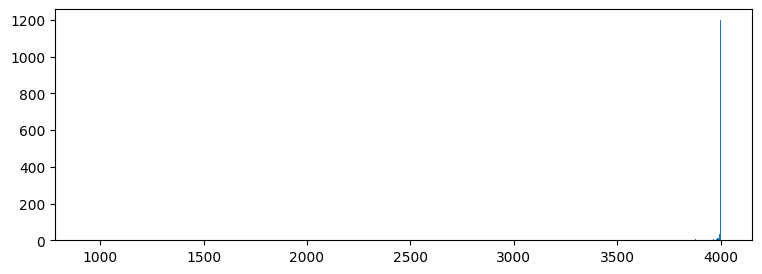

In [27]:
#Plot of all the integer values found
fig = plt.figure(figsize=(9,3))
plt.bar(max_pitch_values, max_pitch_counts)
plt.show()

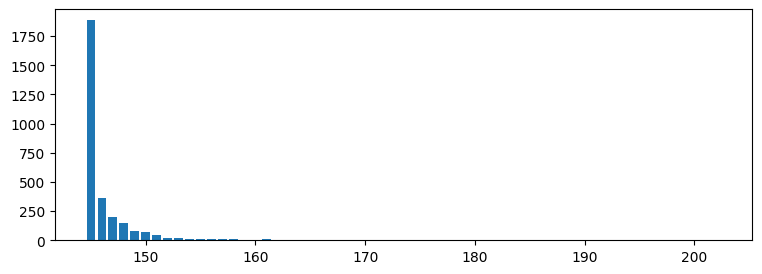

In [28]:
#Same for min_pitch values
min_pitch_values, min_pitch_counts = np.unique(np.floor(data['min_pitch']), return_counts=True)
fig = plt.figure(figsize=(9,3))
plt.bar(min_pitch_values, min_pitch_counts)
plt.show()

Trend of mean-pitch at age variation

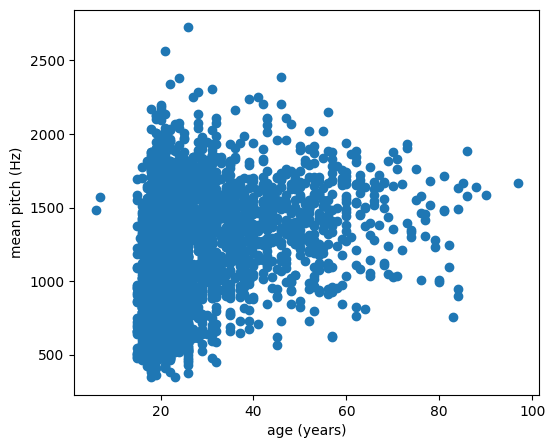

In [29]:
fig = plt.figure(figsize=(6,5))
plt.scatter(data['age'], data['mean_pitch'])
plt.xlabel('age (years)')
plt.ylabel('mean pitch (Hz)')
plt.show()

#### Silence duration

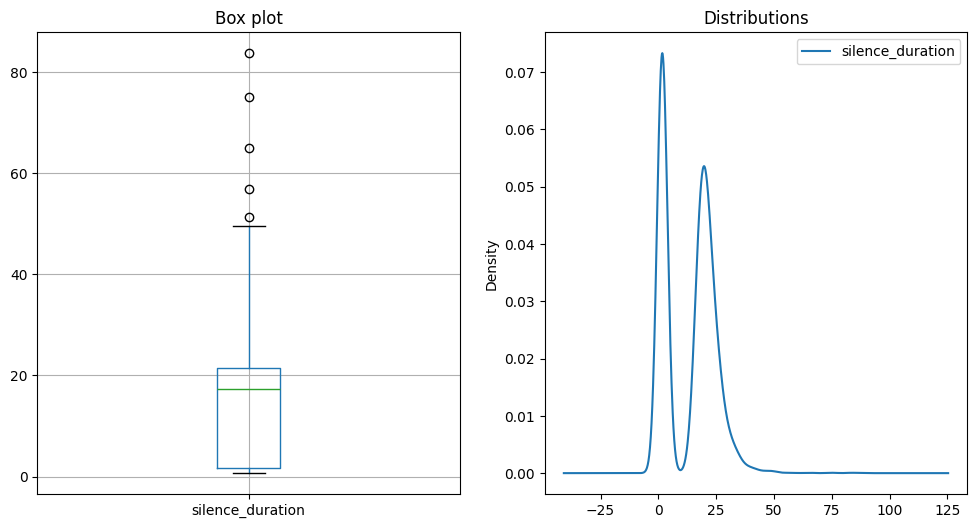

In [30]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
data[['silence_duration']].boxplot(ax=axs[0])
axs[0].set_title('Box plot')
data[['silence_duration']].plot.density(ax=axs[1],legend=True)
axs[1].set_title('Distributions')
plt.show()

Similar distribution to audio lengths

Trend of silence duration at age variation

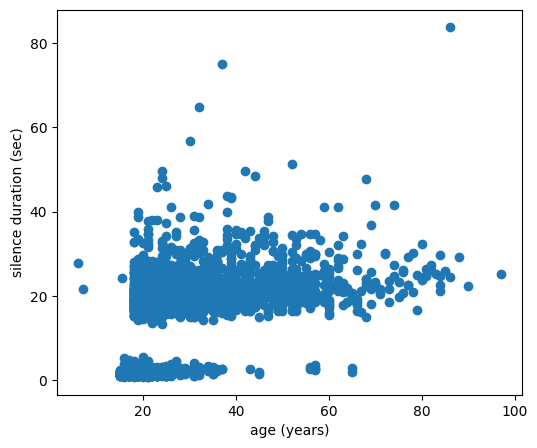

In [31]:
fig = plt.figure(figsize=(6,5))
plt.scatter(data['age'], data['silence_duration'])
plt.xlabel('age (years)')
plt.ylabel('silence duration (sec)')
plt.show()

#### Number of characters and words

<Axes: xlabel='num_words'>

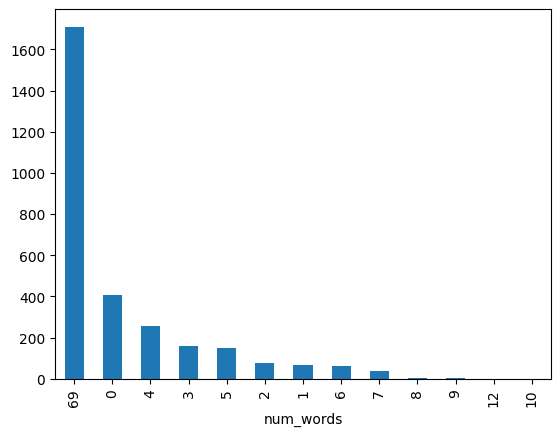

In [32]:
data['num_words'].value_counts().plot.bar()

<Axes: xlabel='num_characters'>

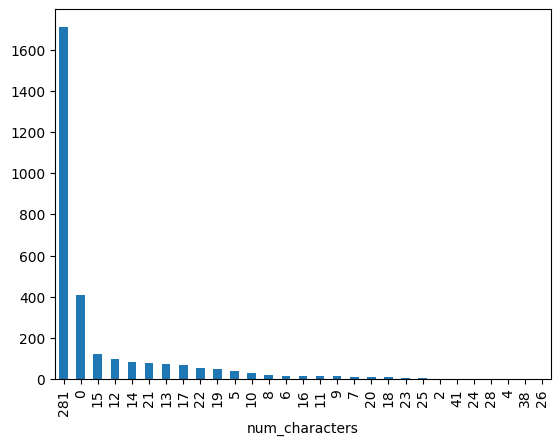

In [33]:
data['num_characters'].value_counts().sort_values(ascending=False).plot.bar()

The number of characters and words in the dataset are not uniformly distributed.

#### Other analyses

In [34]:
#Convert to numerical the features "gender" and "tempo"
data['gender'] = data['gender'].map(lambda x: 1 if x=='male' else 0)
data['tempo'] = data['tempo'].map(lambda x: float(x[1:-1]))
data['path'] = data['path'].map(lambda x: x.split('/')[-1])

##### Correlation

<Axes: >

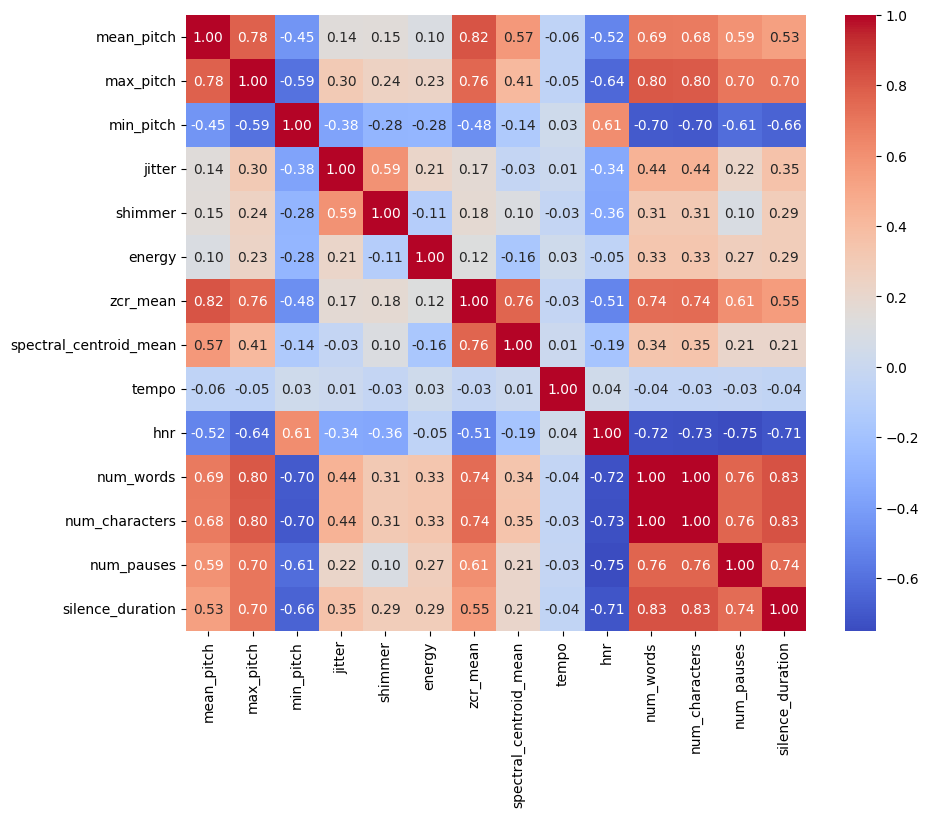

In [35]:
#Spearman correlation between features
res = sp.stats.spearmanr(data.iloc[:,4:-1])
corr_matrix = pd.DataFrame(res.statistic, index=data.iloc[:,4:-1].columns, columns=data.iloc[:,4:-1].columns)
plt.figure(figsize=(10, 8))
sn.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

Strong positive or negative correlation between the last 5 features

##### Relation between ethnicity, number of words/characters and audio length

In [36]:
sentence_feat = data.loc[:,['num_words','num_characters']].values  #Extraction of sentence informations (number of words and characters)
uniq, ind, count= np.unique(np.array(sentence_feat), return_counts=True, return_inverse=True, axis=0)  #Count of unique sentence features
display(count)

array([ 409,    2,    1,   39,    8,    5,    2,    3,    3,    3,    1,
          8,    5,   19,    9,   16,    7,    7,    1,    4,    1,    2,
          9,    8,   27,   66,   26,    6,    5,    7,    2,   58,    1,
         52,   56,    6,   51,    5,    9,    4,    8,    4,    1,    2,
          3,    3,   15,    1,    6,    2,   28,    3,   55,   28,    3,
          1,   44,    1,    1,    5,    4,    5,    1,    1,    1,    2,
          6,    3,   11,   16,    1,    1,    1,    1,    1,    1, 1710])

In [37]:
#Most common number of words and characters combination
print(uniq[-1])

[ 69 281]


We devide samples in 2 groups based on the number of words/characters. The ones with 69 words and 281 characters are defined as long audios, and the others as short audios.

In [38]:
data_with_lengths = data.join(time_stamps, 'path').drop(columns=['path'])
long_data = data_with_lengths[ind==76]
short_data = data_with_lengths[ind!=76]

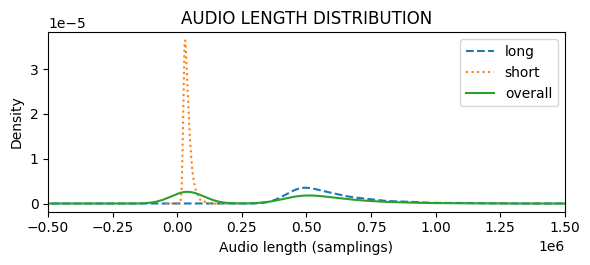

In [41]:
fig, ax = plt.subplots(figsize=(6,2.75))
long_data['length'].plot.density(ax=ax,linestyle='--', label='long')
short_data['length'].plot.density(ax=ax,linestyle=':',label='short')
time_stamps.plot.density(ax=ax,label='overall')
ax.set_xlim([-0.5e6, 1.5e6])
ax.set_title('AUDIO LENGTH DISTRIBUTION')
ax.set_xlabel('Audio length (samplings)')
plt.tight_layout()
plt.legend()
#plt.savefig('lenghtsDistribution.jpg',dpi=300)
plt.show()

In green the overal lengths distribution, in blu the one for long audios and in orange the one for short audios.
We can see that "long audios" correspond to the ones with the highest number of time samplings (peak on the right), and that "short audios" correspond to the ones with the lowest number of time samplings (peak on the left).

In [40]:
#Ethnicities sorted by number of samples
print('LONG DATA')
ethnicity_values_long, ethnicity_counts = np.unique(long_data['ethnicity'], return_counts=True)
ethnicity_data = pd.DataFrame(np.vstack((ethnicity_values_long,ethnicity_counts)).transpose(), columns=['value','count'])
ethnicity_data_ordered = ethnicity_data.sort_values(by=['count'], ascending=False)
display(ethnicity_data_ordered.iloc[:,:])

print('SHORT DATA')
ethnicity_values_short, ethnicity_counts = np.unique(short_data['ethnicity'], return_counts=True)
short_in_long = ethnicity_values_short.copy()
for i,x in enumerate(ethnicity_values_short):  #Look for ethnicity in short data which are also present in long data
    if x in ethnicity_values_long:
        short_in_long[i] = True
    else:
        short_in_long[i] = False
ethnicity_data = pd.DataFrame(np.vstack((ethnicity_values_short,ethnicity_counts,np.array(short_in_long))).transpose(), columns=['value','count','in long'])
ethnicity_data_ordered = ethnicity_data.sort_values(by=['count'], ascending=False)
display(ethnicity_data_ordered.iloc[:,:])

LONG DATA


,value,count
38,english,579
5,arabic,102
109,mandarin,65
49,french,63
92,korean,52
...,...,...
1,akan,1
74,ilonggo,1
72,ife,1
67,hindko,1


SHORT DATA


,value,count,in long
7,igbo,1078,True
16,urhobo,32,False
5,ibibio,24,True
6,igala,22,False
3,congolese,13,False
17,yoruba,12,False
13,obudu,10,False
9,ika,10,False
14,tiv,4,False
8,ijaw,2,False


Most of the ethnicities are present only in one set between long and short data.